In [29]:
import optuna
from optuna import Trial

from math import sqrt
from typing import Tuple, List

import numpy as np
import pandas as pd
from mordred import Calculator, descriptors
#import openbabel
from openbabel import pybel
from PyBioMed.PyMolecule.fingerprint import CalculatePubChemFingerprint,CalculateECFP2Fingerprint
from rdkit import Chem
from rdkit.Chem.rdchem import Atom

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as G_Loader 
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import BatchNorm


# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs

# Pytorch and Pytorch Geometric
import torch

import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
import torch.nn.functional as F # activation function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as V_Loader # dataset management

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# performances visualization 
import matplotlib.pyplot as plt
#import seaborn as sns
import statistics
from prettytable import PrettyTable
%run ./my_performances.ipynb 


#%run ./graph_feature.ipynb 
#%run ./dataset_processing.ipynb 

In [2]:
# reload the data fingerprint 
#=======================================================
k=10
final_clean_fingerp_train=[]
final_clean_fingerp_val=[]
for i in range(k):
    final_clean_fingerp_train.append(np.load('final_clean_fingerp_train'+ str(i)+'.npy'))
    final_clean_fingerp_val.append(np.load('final_clean_fingerp_val' +str(i)+'.npy'))

final_clean_fingerp_test = np.load('final_clean_fingerp_test.npy')

In [3]:
train_idx = np.load('train_indices.npy')
val_idx = np.load('val_indices.npy')
test_idx = np.load('test_indices.npy')

In [4]:
# load the output label 
total_train_targets =[]
total_validation_targets =[]
total_test_targets=[]
for i in range(k):
    total_train_targets.append(np.load('total_train_targets'+ str(i)+'.npy'))
    total_validation_targets.append(np.load('total_validation_targets' +str(i)+'.npy'))

total_test_targets= np.load('total_test_targets.npy')

In [5]:
# create dataloader for training (vector data)
#======================================================================================
list_data_fingerp_train =[]
list_data_fingerp_val =[]
list_data_target_train =[]
list_data_target_val =[]

for data_train, data_val, tr_targets, val_targets in zip(final_clean_fingerp_train, final_clean_fingerp_val,total_train_targets, total_validation_targets):
    train_loader = V_Loader(dataset = data_train, batch_size = 126)
    val_loader = V_Loader(dataset = data_val, batch_size = 126)
    
    tr_target_loader = V_Loader(dataset = tr_targets, batch_size = 126)
    val_target_loader =  V_Loader(dataset = val_targets, batch_size = 126)
    
    list_data_fingerp_train.append(train_loader)
    list_data_fingerp_val.append(val_loader)
    
    list_data_target_train.append(tr_target_loader)
    list_data_target_val.append(val_target_loader)

In [6]:
# load structured graph data
train_idx = np.load('train_indices.npy')
val_idx = np.load('val_indices.npy')
test_idx = np.load('test_indices.npy')

k=10
data_list_train=[]
for i in range(k):
    one_fold= []
    for idx in range(train_idx[i]):
        one_graph_data =torch.load(f"data_train_{i}/tensor{idx}.pt")
        one_fold.append(one_graph_data)
    data_list_train.append(one_fold)
    
data_list_val=[]
for i in range(k):
    one_fold= []
    for idx in range(val_idx[i]):
        one_graph_data =torch.load(f"data_val_{i}/tensor{idx}.pt")
        one_fold.append(one_graph_data)
    data_list_val.append(one_fold)
    
data_list_test =[]
for idx in range(test_idx):
    one_graph_data =torch.load(f"data_test/tensor{idx}.pt")
    data_list_test.append(one_graph_data)
    
# load the output label 
total_train_targets =[]
total_validation_targets =[]
total_test_targets=[]
for i in range(k):
    total_train_targets.append(np.load('total_train_targets'+ str(i)+'.npy'))
    total_validation_targets.append(np.load('total_validation_targets' +str(i)+'.npy'))

total_test_targets= np.load('total_test_targets.npy')

In [7]:
# create dataloader for training (graph data)
#======================================================================================
list_data_graph_train =[]
list_data_graph_val =[]
for data_train, data_val in zip(data_list_train, data_list_val):
    train_loader = G_Loader(dataset = data_train, batch_size = 126)
    val_loader = G_Loader(dataset = data_val, batch_size = 126)
    list_data_graph_train.append(train_loader)
    list_data_graph_val.append(val_loader)

# create dataloader for test (graph data)
#======================================================================================
g_test_loader = G_Loader(dataset = data_list_test, batch_size = 1)

In [8]:
#criterion = torch.nn.CrossEntropyLoss()
#define the loss function 
criterion = torch.nn.BCELoss()

In [9]:
# input for forward the model x, edge_attr, edge_index, batch_index
def train_1(g_loader,f_loader, combined_model, optimizer):
    combined_model.train()
    
    for data_X1, data_X2 in zip(g_loader, f_loader):  # Iterate in batches over the training dataset.
        
        out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                             torch.tensor(data_X2, dtype=torch.float32))  # Perform a single forward pass.
        
        y_t = data_X1.y.type(torch.FloatTensor)
        loss = criterion(out[:,0], y_t)  # Compute the loss.
        #print(k)
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss, combined_model, optimizer

def validation_1(g_loader,f_loader,combined_model):
    for data_X1, data_X2 in zip(g_loader,f_loader): # Iterate in batches over the training dataset.
        out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                             torch.tensor(data_X2, dtype=torch.float32))  # Perform a single forward pass.
        
        y_t = data_X1.y.type(torch.FloatTensor)
        val_loss = criterion(out[:,0], y_t)  # Compute the loss.
        
    return val_loss

In [10]:
def test_1(g_loader,f_loader,combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X1, data_X2 in zip(g_loader,f_loader): # Iterate in batches over the training dataset.
        out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                             torch.tensor(data_X2, dtype=torch.float32))  # Perform a single forward pass.
        out_1 = out[:,0] 
        list_pred.append(out_1.item())
        list_targets.append(data_X1.y.item())
    return list_pred, list_targets 

# used to count the train accuracy ,and validation accuracy when in the training mode 
def test(g_loader,f_loader,combined_model):
    combined_model.eval()

    correct = 0
    for data_X1, data_X2 in zip(g_loader,f_loader): # Iterate in batches over the training dataset.
        out = combined_model(data_X1.x, data_X1.edge_index, data_X1.batch, 
                             torch.tensor(data_X2, dtype=torch.float32))  # Perform a single forward pass.
        out_1 = out[:,0]
        for i,value in enumerate(out_1) :
            if value > 0.5 :
                out_1[i] = 1
            else : out_1[i] = 0
        pred = out_1  # Use the class with highest probability.
        correct += int((pred == data_X1.y).sum())  # Check against ground-truth labels.
    return correct / len(g_loader.dataset)  # Derive ratio of correct predictions.

In [11]:
def get_optimizer(gnn_model, learning_rate, optimizer_type, weight_decay=1e-4):
    if optimizer_type==1:
        optimizer = torch.optim.SGD(gnn_model.parameters(), lr=learning_rate, momentum=0.9)
    if optimizer_type==2:
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if optimizer_type ==3 :
        optimizer = torch.optim.Adamax(gnn_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
        
    return optimizer

In [12]:
class modelA(torch.nn.Module):
    def __init__(self, hidden_channels1,hidden_channels2, num_node_features,heads1,heads2
                 ,dropout_rateA,dropout_rateB, dropout_rateC,dense_layer1):
        super(modelA, self).__init__()
        
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels1,heads1)
        self.conv2 = GATConv(hidden_channels1*heads1,hidden_channels2, heads2)
        
        self.bn1 = BatchNorm (hidden_channels1*heads1)
        self.bn2 = BatchNorm (hidden_channels2*heads2)
        
        self.dropoutA = dropout_rateA
        self.dropoutB = dropout_rateB
        self.dropoutC = dropout_rateC
        
        self.lin1 = Linear(hidden_channels2*heads2,dense_layer1)
        #self.lin1 = Linear(hidden_channels2*heads2,dense_layer1)
        self.lin2=  Linear(dense_layer1,1)
        
    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)
        
        x = F.dropout(x, p=self.dropoutA , training=self.training)
        x = x.relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index)
        
        x = F.dropout(x, p=self.dropoutB , training=self.training)
        x = x.relu()
        x = self.bn2(x)  
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = self.lin1(x)
        x = F.dropout(x, p=self.dropoutC , training=self.training)
        x = x.relu()
        x = self.lin2(x)
        return torch.sigmoid(x)


class modelB(torch.nn.Module):
    def __init__(self, input_features, output_features,dropout_rateB1,dropout_rateB2,dropout_rateB3,  
                 dense_layer1,dense_layer2, dense_layer3):
        super(modelB, self).__init__()
        self.lin1 = nn.Linear(input_features,dense_layer1)
      
        self.lin2 = nn.Linear(int(dense_layer1), dense_layer2)
        self.lin3 = nn.Linear(int(dense_layer2), dense_layer3)
        self.lin4 = nn.Linear(int(dense_layer3), output_features)
        
        self.bn1 = nn.BatchNorm1d(int(dense_layer1))
        self.bn2 = nn.BatchNorm1d(int(dense_layer2))
        self.bn3 = nn.BatchNorm1d(int(dense_layer3))
        self.dropoutB1 = dropout_rateB1
        self.dropoutB2 = dropout_rateB2
        self.dropoutB3 = dropout_rateB3
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
       
        x = F.dropout(x, p= self.dropoutB1, training=self.training)
        x = x.relu()
  #      
        x = self.lin2(x)
        x = self.bn2(x)   
        x = F.dropout(x, p= self.dropoutB2, training=self.training)
        x = x.relu()
  #      
        x = self.lin3(x)
        x = self.bn3(x)   
        x = F.dropout(x, p= self.dropoutB3, training=self.training)

        x = x.relu()
        x = self.lin4(x)
        return torch.sigmoid(x)        
    
class Combined_model(nn.Module):
    def __init__(self, modelA, modelB, total_input_features, num_classes,dropout_rate_C, dense_layer_C):
        super(Combined_model, self).__init__()
        self.model_1 = modelA
        self.model_2 = modelB
        
        
        self.lin1 = Linear(total_input_features,int(dense_layer_C))
        self.lin2 = Linear(int(dense_layer_C),num_classes)
        
        self.dropout_C = dropout_rate_C
        
    def forward(self, x1,edge_index, batch, x2):
        xa = self.model_1(x1, edge_index, batch) # x1 node features in graph
        xb= self.model_2(x2)                     # x2 is a vector features 
  #      xc= self.model_3(x3)                     # x2 is a vector features 
        
        x = torch.cat((xa, xb), dim=1)
  #      x = torch.cat((x, xc), dim=1)
         # 3. Apply a final classifier
        x = self.lin1(x)
        x = F.dropout(x, p= self.dropout_C, training=self.training)
        x = x.relu()
        x = self.lin2(x)
        return torch.sigmoid(x)

In [13]:
hyper_param_d = {'dropout_rateB1': 0.19029920767006717,
               'dropout_rateB2': 0.12142154817498285,
               'dropout_rateB3': 0.30892320125476364,
               'dense_layer1'  : 180,
               'dense_layer2'  : 96,
               'dense_layer3'  : 40,
               'learning_rate' : 0.00014475405687104653,
               'weight_decay'  : 0.0001839631656485908}

In [14]:
hyper_param_g = {'hidden_channels1': 82,
                 'hidden_channels2': 82,
                 'num_node_features': 79,
                 'heads1':9,
                 'heads2':9,
                 'dropout_rateA':0.20184714781996305,
                 'dropout_rateB':0.26157496401430025,
                 'dropout_rateC':0.12826012269932247,
                 'dense_layer1':64}

In [15]:
hyper_param_c = {'total_input_features':2,
                 'num_classes':1,
                 'dropout_rate_C':0.3054920980974637,
                 'dense_layer_C':16}

In [16]:
# load the combined model 
k =10
list_modelA = []
list_modelB = []
list_modelC = []

# load model B
for i in range(k):
    
    input_features    = 166 # length of feature data vector 
    output_features   = 1
    
    dropout_rateB1 =hyper_param_d['dropout_rateB1']
    dropout_rateB2 =hyper_param_d['dropout_rateB2']
    dropout_rateB3 =hyper_param_d['dropout_rateB3']
    dense_layer1 = hyper_param_d['dense_layer1']
    dense_layer2 = hyper_param_d['dense_layer2']
    dense_layer3 = hyper_param_d['dense_layer3']
 
        
    model_b= modelB(input_features, output_features,dropout_rateB1,dropout_rateB2,dropout_rateB3,  
                 dense_layer1,dense_layer2, dense_layer3)
#    PATH = '0.39289model_fingerp'+ str(i)+'.pth'
#    model_b.load_state_dict(torch.load(PATH))
    
    list_modelB.append(model_b)

# load model A
for i in range(k):
    hidden_channels1=hyper_param_g['hidden_channels1']
    hidden_channels2=hyper_param_g['hidden_channels2']
    num_node_features=hyper_param_g['num_node_features']
    heads1=hyper_param_g['heads1']
    heads2=hyper_param_g['heads2']
    dropout_rateA=hyper_param_g['dropout_rateA']
    dropout_rateB=hyper_param_g['dropout_rateB']
    dropout_rateC=hyper_param_g['dropout_rateC']
    dense_layer1=hyper_param_g['dense_layer1']
    
    model_a  = modelA(hidden_channels1,hidden_channels2, num_node_features,heads1,heads2
                 ,dropout_rateA,dropout_rateB, dropout_rateC,dense_layer1)
   
    list_modelA.append(model_a)
    
# load model C (combined model)
for i in range(k):
    
    model_a  = list_modelA[i]
        
    model_b  = list_modelB[i] # model b is pretrained model trainable = off 
    
    total_input_features=hyper_param_c['total_input_features']
    num_classes=hyper_param_c['num_classes']
    dropout_rate_C=hyper_param_c['dropout_rate_C']
    dense_layer_C=hyper_param_c[ 'dense_layer_C']
    
    combined_model = Combined_model(model_a, model_b, total_input_features, num_classes,dropout_rate_C, dense_layer_C) 
    
    PATH = '0.75144model_hybrid'+ str(i)+'.pth'
    combined_model.load_state_dict(torch.load(PATH))
    
    list_modelC.append(combined_model)

In [17]:
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]


v_test_loader = V_Loader(dataset = final_clean_fingerp_test, batch_size = 1)

g_test_loader = G_Loader(dataset = data_list_test, batch_size = 1)


for combined_model in list_modelC:  
    list_pred, list_targets = test_1(g_test_loader, v_test_loader,combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
total_performances = performances(list_fold_pred, list_fold_targets, nCV)
mcc = statistics.mean(total_performances[3])
acc = statistics.mean(total_performances[0])
print(" ")
print(f'The average of mcc : {mcc}')
print(" ")
print(f'The average of acc : {acc}')

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 
The average of mcc : 0.39901
 
The average of acc : 0.75144


In [18]:
import statistics
from prettytable import PrettyTable
perf = total_performances
model_title = 'Test hybrid model'
data_type ='graph-struct & vector'
Create_Tables(perf, model_title, data_type)

+-------------------+-----------------------+-------+-------+-------+-------+-------+---------+---------+-----------+-------+
|     Model Name    |       Data Type       | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |  m_F1 |
+-------------------+-----------------------+-------+-------+-------+-------+-------+---------+---------+-----------+-------+
| Test hybrid model | graph-struct & vector | 0.751 | 0.852 | 0.529 | 0.399 | 0.757 |  0.396  |  0.757  |    0.69   | 0.825 |
+-------------------+-----------------------+-------+-------+-------+-------+-------+---------+---------+-----------+-------+
+-------------------+-----------------------+-------+-------+-------+-------+-------+---------+---------+-----------+-------+
|     Model Name    |       Data Type       | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |  e_F1 |
+-------------------+-----------------------+-------+-------+-------+-------+-------+---------+---------+-----------+-

In [19]:
def plot_ROC( method, total_performances):
    i =0
    total_data_roc = total_performances[5]
    for data_roc in total_data_roc:
    # plot ROC 
        fpr,tpr = data_roc[0], data_roc[1]
        plt.plot(fpr,tpr,marker='.',linestyle='--', label=method+'_fold_'+ str(i)+ ' AUC(' +str(total_performances[4][i])+')' )
        i = i+1
# axis labels
    plt.plot([0,1],[0,1],marker='.',linestyle='--',color='k')
    plt.title('ROC Curve for ' + str(method))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
# show the legend
    plt.legend()
# show the plot
    plt.show()
    
def plot_PR(total_data_pr, method):
    i =0
    for data_pr in total_data_pr:
    # plot PR 
        prec,rec = data_pr[0], data_pr[1]
        plt.plot(rec,prec,marker='.',linestyle='--', label=method+'_fold_'+ str(i))
        i = i+1
# axis labels
    plt.plot([0,1],[1,0], marker='.',linestyle='--',color='k')
    plt.title('PR Curve for ' + str(method))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
# show the legend
    plt.legend()
# show the plot
    plt.show()

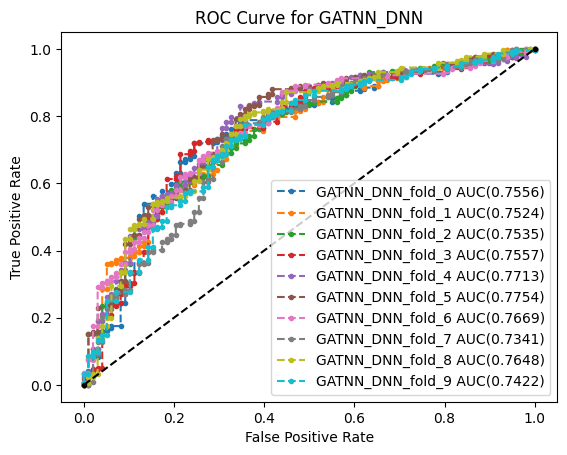

In [20]:
plot_ROC('GATNN_DNN', total_performances)

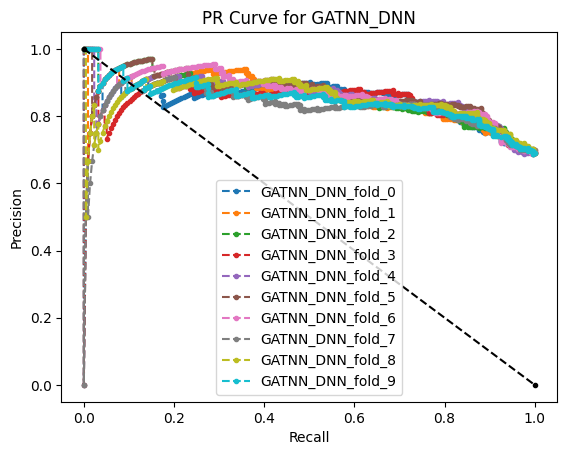

In [21]:
total_PR = total_performances[6]
plot_PR(total_data_pr=total_PR, method="GATNN_DNN")